In [1]:
%matplotlib inline
import plot
import market
import metrics
from decimal import Decimal
import pandas

/Users/justus/anaconda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


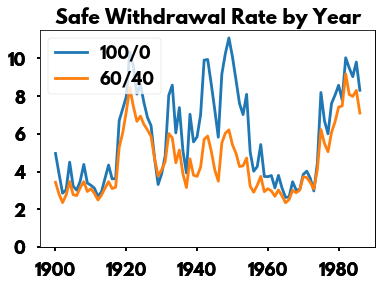

In [2]:
m = market.Returns_US_1871()
years = 30
start_year = 1900
last_year = 2016-years

def run(stock_pct):
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
#        if start_year + _ in (1965,1966,1967,1968,1969): continue
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        #swr = float(metrics.ssr(returns))
        swr = float(metrics.pwa(100, 100, returns))
#        print(start_year+_, swr)
        swrs.loc[start_year+_] = swr
    return swrs


two = run(Decimal('.2'))
three = run(Decimal('.3'))
four = run(Decimal('.4'))
five = run(Decimal('.5'))
six = run(Decimal('.6'))
eight = run(Decimal('.8'))
nine = run(Decimal('.9'))
ten = run(Decimal('1'))


plot.plot_n({'60/40': six, '100/0' : ten}, '', 'Safe Withdrawal Rate by Year', add_commas=False)

#diff = filter(lambda x: x>0, [(x[0] - x[1])*100 for x in zip(eight, four)])
#plot.plot_n({'80/20 - 40/60' : list(diff)}, '', 'SWR Tell Tale Chart', add_commas=False, zero_based=False)

In [3]:
a = ten
print(a.sort_values()[0:10])
print(a.median())
print(a.quantile(.1))

1965    2.633283
1966    2.655604
1912    2.687340
1902    2.857800
1913    2.934670
1973    2.976459
1906    3.016079
1968    3.028841
1903    3.037515
1969    3.042198
dtype: float64
5.435728139875476
3.0403247391363712


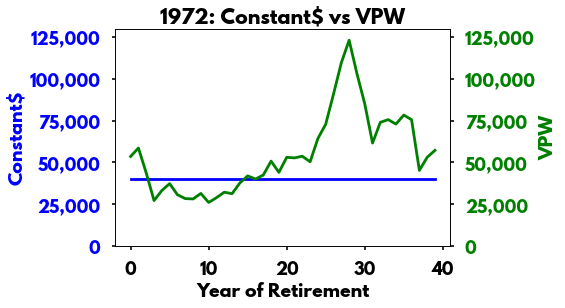

In [10]:
import itertools
from simulate import simulate_withdrawals
from harvesting import N_60_RebalanceHarvesting, N_100_RebalanceHarvesting
import withdrawal
import math
from plot import plot_two

def compare_em_vs_vpw(series, years=40, title=''):
    (r1, r2) = itertools.tee(series)
    portfolio = (1000000, 0)
    x = simulate_withdrawals(r1, years=years, harvesting=N_100_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.ConstantDollar(p, h, rate=Decimal('0.04')), portfolio=portfolio)
    y = simulate_withdrawals(r2, years=years, harvesting=N_100_RebalanceHarvesting, withdraw=lambda p, h: withdrawal.VPW(p, h, years_left=45), portfolio=portfolio)

    s1 = [n.withdraw_r for n in x]
    s2 = [n.withdraw_r for n in y]

    ceiling = max(max(s1), max(s2))
    if ceiling < 200000:
        ceiling = int(math.ceil(ceiling / 10000) * 10000)
    else:
        ceiling = int(math.ceil(ceiling / 100000) * 100000)
    
    plot_two(s1, s2, s1_title='Constant$', s2_title='VPW',
                       y_lim=[0,ceiling],
                       x_label='Year of Retirement', title=title)

def em_vs_vpw(year, years=40):
    compare_em_vs_vpw(m.iter_from(year), title='%d: Constant$ vs VPW' % year, years=years)

em_vs_vpw(1972, years=40)

In [5]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2016-years

def get_stock_pct(year):
    if year < 10:
        return Decimal('.4')
    elif year < 20:
        return Decimal('.5')
    else:
        return Decimal('.6')


def run():
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stock_pct = get_stock_pct(one_year[0])
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
        swrs.loc[start_year+_] = swr
    return swrs

values = run()
values.sort_values()

1899    0.036203
1966    0.037072
1906    0.037914
1965    0.038107
1968    0.038583
1909    0.038705
1964    0.039015
1969    0.039229
1962    0.039374
1912    0.039383
1911    0.039541
1967    0.039620
1901    0.039703
1916    0.039739
1902    0.039806
1907    0.040300
1898    0.040604
1963    0.040687
1905    0.040916
1910    0.041111
1897    0.041358
1973    0.041506
1913    0.041922
1937    0.042154
1972    0.042282
1961    0.042795
1914    0.042804
1903    0.042845
1900    0.043011
1971    0.043501
          ...   
1884    0.065323
1882    0.065627
1948    0.066401
1880    0.067084
1927    0.067192
1949    0.067367
1919    0.068931
1926    0.070026
1979    0.071636
1876    0.072924
1878    0.072925
1925    0.073385
1875    0.076710
1923    0.076760
1986    0.077600
1924    0.077880
1871    0.078048
1872    0.078968
1980    0.079388
1877    0.079856
1920    0.081086
1873    0.081263
1922    0.081329
1874    0.081337
1981    0.084352
1984    0.086709
1983    0.086808
1985    0.0877

In [6]:
import scipy.stats

def run():
    m = market.Returns_US_1871()
    years = 35
    start_year = 1871
    last_year = 2017-years
    stock_pct = Decimal('.6')

    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stock_pct = stock_pct
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
        swrs.loc[start_year+_] = swr
    return swrs

values = run()

scipy.stats.percentileofscore(values, .04)

15.178571428571427

In [7]:
m = market.Returns_US_1871()
years = 30
start_year = 1871
last_year = 2016-years

def get_stock_pct(stocks, bonds):
    if stocks < bonds:
        return Decimal('.4')
    else:
        return Decimal('.6')

def run():
    swrs = pandas.Series()
    for _ in range(last_year - start_year + 1):
        returns = []
        for one_year in zip(range(years), m.iter_from(start_year + _)):
            annual_returns = one_year[1]
            stocks = annual_returns.stocks - annual_returns.inflation
            bonds = annual_returns.bonds - annual_returns.inflation
            stock_pct = get_stock_pct(stocks, bonds)
            returns.append((stocks * stock_pct) + (bonds * (1-stock_pct)))
        swr = float(metrics.ssr(returns))
        swrs.loc[start_year+_] = swr
    return swrs

run().sort_values()

1966    0.043682
1968    0.044325
1965    0.044701
1969    0.044805
1906    0.045475
1899    0.045632
1909    0.046274
1912    0.046571
1911    0.046674
1967    0.047383
1964    0.047546
1973    0.047900
1916    0.048470
1910    0.048647
1962    0.048771
1902    0.048913
1907    0.049128
1905    0.049312
1901    0.049820
1913    0.049877
1972    0.050019
1937    0.051085
1963    0.051367
1898    0.051577
1971    0.051736
1914    0.051894
1970    0.052415
1903    0.053109
1939    0.053718
1908    0.054012
          ...   
1951    0.082890
1932    0.083103
1979    0.083370
1876    0.083992
1875    0.086316
1948    0.086878
1878    0.087120
1950    0.087267
1871    0.088003
1919    0.088017
1872    0.088102
1986    0.089322
1927    0.090356
1873    0.090545
1874    0.091031
1980    0.091727
1926    0.091805
1949    0.092376
1981    0.093004
1877    0.093722
1925    0.094880
1923    0.095578
1984    0.097217
1983    0.098314
1985    0.100247
1920    0.101148
1924    0.101615
1922    0.1033

In [8]:
print(six[1966])

2.5197863985999343
